# Submission 2 - Movie Recommendation

# Import Library

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from google.colab import files
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Data Collection

In [ ]:
!pip install -q kaggle

In [ ]:
!kaggle datasets download -d parasharmanas/movie-recommendation-system

Dataset URL: https://www.kaggle.com/datasets/parasharmanas/movie-recommendation-system
License(s): ODbL-1.0
 83% 137M/165M [00:00<00:00, 276MB/s]
100% 165M/165M [00:00<00:00, 279MB/s]


# Data Understanding

Pada tahap ini dilakukan untuk memahami dataset secara keseluruhan sebelum dilakukan pre-processing dan pemodelan

## Data Loading

Tahap ini dilakukan untuk memuat dataset agar lebih mudah digunakan.

In [ ]:
import zipfile

with zipfile.ZipFile('/content/movie-recommendation-system.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

In [ ]:
data_movies = pd.read_csv('/content/movies.csv')
data_rating = pd.read_csv('/content/ratings.csv')

In [ ]:
data_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
data_rating.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


# Exploratory Data Analysis

## Checking Dataset

In [ ]:
data_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [ ]:
data_movies.describe()

,movieId
count,62423.000000
mean,122220.387646
std,63264.744844
min,1.000000
25%,82146.500000
50%,138022.000000
75%,173222.000000
max,209171.000000


In [ ]:
data_movies.shape

(62423, 3)

Untuk data pada dataset movies didapatkan hasil bahwa dataset memiliki data berjumlah 62423 dan 3 kolom.

In [ ]:
data_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 762.9 MB


In [ ]:
data_rating.describe()

,userId,movieId,rating,timestamp
count,2.500010e+07,2.500010e+07,2.500010e+07,2.500010e+07
mean,8.118928e+04,2.138798e+04,3.533854e+00,1.215601e+09
std,4.679172e+04,3.919886e+04,1.060744e+00,2.268758e+08
min,1.000000e+00,1.000000e+00,5.000000e-01,7.896520e+08
25%,4.051000e+04,1.196000e+03,3.000000e+00,1.011747e+09
50%,8.091400e+04,2.947000e+03,3.500000e+00,1.198868e+09
75%,1.215570e+05,8.623000e+03,4.000000e+00,1.447205e+09
max,1.625410e+05,2.091710e+05,5.000000e+00,1.574328e+09


In [ ]:
data_rating.shape

(25000095, 4)

Untuk data pada dataset ratings didapatkan hasil bahwa dataset memiliki data berjumlah 25000095 dan 4 kolom. Namun karena resource yang saya miliki tidak begitu besar, maka data yang akan dipakai hanya 50000.

In [ ]:
data_ratings = data_rating.sample(n=50000, random_state=42)

In [ ]:
data_ratings

,userId,movieId,rating,timestamp
15347762,99476,104374,3.5,1467897440
16647840,107979,2634,4.0,994007728
23915192,155372,1614,3.0,1097887531
10052313,65225,7153,4.0,1201382275
12214125,79161,500,5.0,1488915363
...,...,...,...,...
18674093,120998,8596,3.5,1093971335
19535136,126848,151315,5.0,1520322201
18309526,118603,2710,1.0,952879431
3444719,22712,1968,4.0,1529264095


Dikarenakan resource yang terbatas, maka hanya digunakan 50000 data.

## Check Missing Value

In [ ]:
data_movies.duplicated().sum()

0

In [ ]:
data_movies.isnull().sum()

,0
movieId,0
title,0
genres,0


In [ ]:
data_ratings.duplicated().sum()

0

In [ ]:
data_ratings.isnull().sum()

,0
userId,0
movieId,0
rating,0
timestamp,0


Dikarenakan pada hasil output tidak terdapat missing value dan data yang duplikat. Maka proses bisa dapat dilanjutkan ke visualisasi.

## EDA - Univariate Visualization

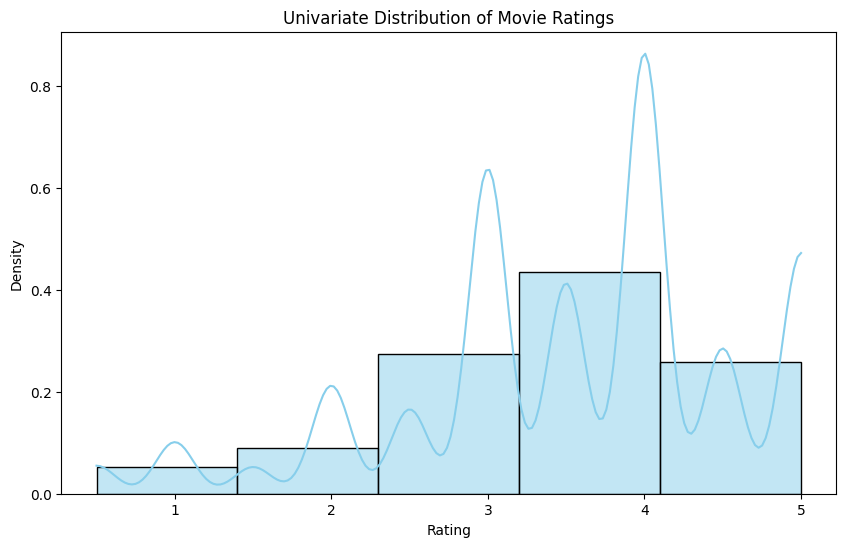

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data_ratings['rating'], bins=5, kde=True, color='skyblue', stat="density")
plt.title("Univariate Distribution of Movie Ratings")
plt.xlabel("Rating")
plt.ylabel("Density")
plt.show()

Pada visualisasi untuk Distribusi dari Rating Movie di dalam data_ratings, dapat dilihat bahwa rating 4 paling sering muncul dengan Density lebih dari 0.4. Kemudian dilanjutkan kepada rating 3 dan 5 yang memiliki density 0.3. Sehingga dapat disimpulkan bahwa pengguna paling sering memberikan rating 4.

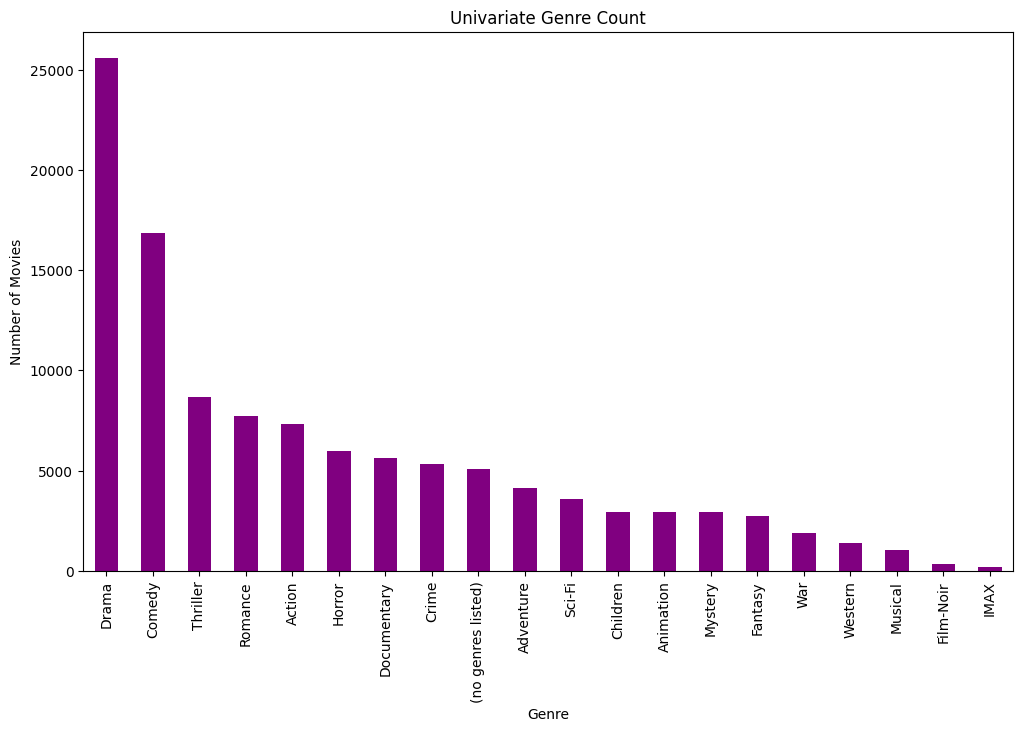

In [ ]:
# Count of movies by genre
genre_count = data_movies['genres'].str.split('|', expand=True).stack().value_counts()

plt.figure(figsize=(12, 7))
genre_count.plot(kind='bar', color='purple')
plt.title("Univariate Genre Count")
plt.xlabel("Genre")
plt.ylabel("Number of Movies")
plt.xticks(rotation=90)
plt.show()

Untuk distribusi movie berdasarkan genre dapat dilihat bahwa genre Drama memiliki peminat yang paling tinggi yaitu 25000 atau 50% dari keseluruhan data. Setelah itu disusul oleh genre comedy yang memiliki peminat 17000. Untuk sisa genre lainnya memiliki peminat yang kurang lebih sama yaitu mulai dari 5000 hingga 10000.

## EDA - Multivariate Visualization

<ipython-input-23-3bb60ae25c1f>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_avg_rating.index, y=genre_avg_rating.values, palette='viridis')


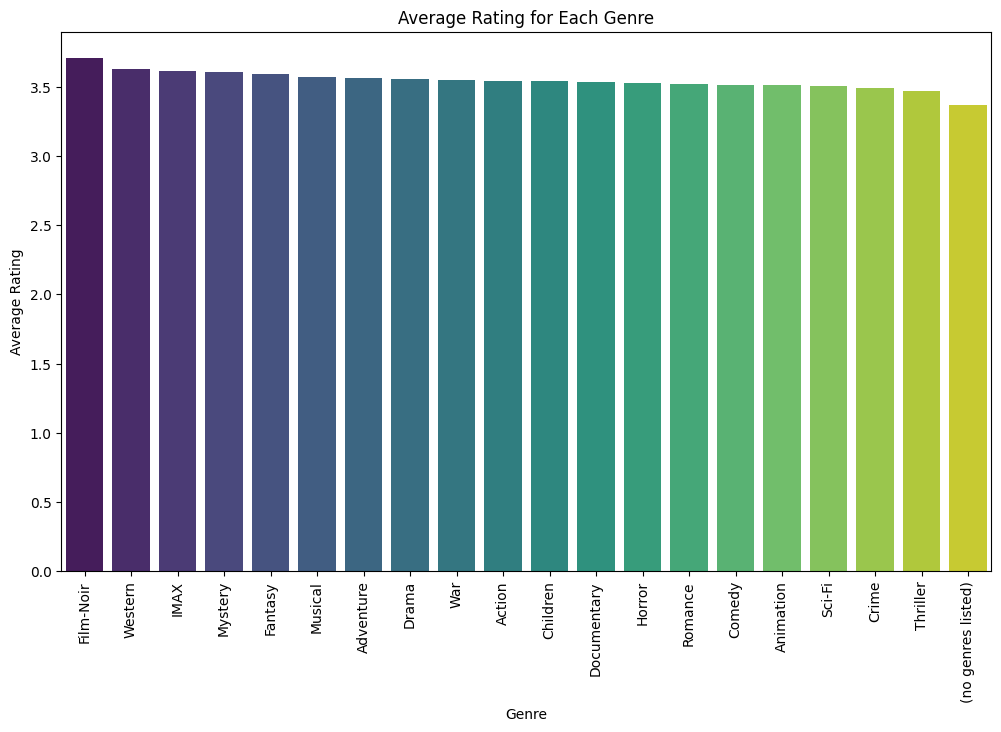

In [ ]:
genre_expanded = data_movies['genres'].str.split('|', expand=True).stack().reset_index(level=1, drop=True)

movie_genres = genre_expanded.to_frame('genre')
movie_genres['movieId'] = movie_genres.index

genre_ratings = pd.merge(movie_genres, data_ratings, on='movieId')

genre_avg_rating = genre_ratings.groupby('genre')['rating'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 7))
sns.barplot(x=genre_avg_rating.index, y=genre_avg_rating.values, palette='viridis')
plt.title("Average Rating for Each Genre")
plt.xlabel("Genre")
plt.ylabel("Average Rating")
plt.xticks(rotation=90)
plt.show()

Untuk distribusi genre berdasarkan rating menunjukkan bahwa hampir semua genre memiliki rating 3.5 namun dapat dilihat untuk Genre Film-Noir memiliki rating yang paling tinggi yaitu 3.7 disusul oleh genre weestern dan IMAX yang memiliki rating 3.6. Untuk sisanya memiliki rating yang hampir sama yaitu 3.5.

# Data Preparation
 Pada tahap ini dilakukan untuk mempersiapkan data sebelum dilakukan pemodelan. Pada proyek kali ini, akan digunakan Content Based Filtering dan Collaborative Filtering. Sebelum masuk ke dalam preparation untuk setiap filtering, maka perlu dicek terlebih dahulu data yang akan digunakan.

In [ ]:
unique_genres = data_movies['genres'].str.split('|', expand=True).stack().unique()
print(unique_genres)

['Adventure' 'Animation' 'Children' 'Comedy' 'Fantasy' 'Romance' 'Drama'
 'Action' 'Crime' 'Thriller' 'Horror' 'Mystery' 'Sci-Fi' 'IMAX'
 'Documentary' 'War' 'Musical' 'Western' 'Film-Noir' '(no genres listed)']


Dikarenakan terdapat data (no genre listed), maka lebih baik dihapus karena akan mengganggu saat pemodelan nanti.

In [ ]:
# Menghapus genre "(no genres listed)" dari data_movies
data_movies_cleaned = data_movies[~data_movies['genres'].str.contains('(no genres listed)', na=False)]

print(data_movies_cleaned['genres'].str.split('|', expand=True).stack().unique())


<ipython-input-25-600d50ef5137>:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  data_movies_cleaned = data_movies[~data_movies['genres'].str.contains('(no genres listed)', na=False)]


['Adventure' 'Animation' 'Children' 'Comedy' 'Fantasy' 'Romance' 'Drama'
 'Action' 'Crime' 'Thriller' 'Horror' 'Mystery' 'Sci-Fi' 'IMAX'
 'Documentary' 'War' 'Musical' 'Western' 'Film-Noir']



## Content-Based Filtering


Untuk content-based filtering, akan digunakan berdasarkan movieId, judul film (title), dan genre.

**Mengubah data menjadi bentuk list**

In [ ]:
# Pada tahap ini dilakukan pengonversian menjadi bentuk list
movieId = data_movies["movieId"].tolist()
title = data_movies["title"].tolist()
genres = data_movies["genres"].tolist()

# Menampilkan banyak data dari masing-masing list
print(len(movieId))
print(len(title))
print(len(genres))

62423
62423
62423


**Membuat DataFrame baru**

Pada DataFrame ini dibuat

In [ ]:
content_based = pd.DataFrame({
    "movieId": movieId,
    "title": title,
    "genres": genres
})
content_based

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
62418,209157,We (2018),Drama
62419,209159,Window of the Soul (2001),Documentary
62420,209163,Bad Poems (2018),Comedy|Drama
62421,209169,A Girl Thing (2001),(no genres listed)


### TF-IDF

Dikarenakan komputer hanya bisa memroses berupa numerik maka diperlukan mengubah data dari string menjadi numerik dengen TFidfVectorizer. Dilakukan konversi untuk kolom genres agar dapat diproses untuk pemodelan nanti.

In [ ]:
tfidf = TfidfVectorizer()

tfidf.fit(content_based["genres"])
tfidf.get_feature_names_out()

array(['action', 'adventure', 'animation', 'children', 'comedy', 'crime',
       'documentary', 'drama', 'fantasy', 'fi', 'film', 'genres',
       'horror', 'imax', 'listed', 'musical', 'mystery', 'no', 'noir',
       'romance', 'sci', 'thriller', 'war', 'western'], dtype=object)

Dilakukan transformasi ke dalam bentuk matriks

In [ ]:
tfidf_matrix = tfidf.fit_transform(content_based["genres"])

tfidf_matrix.shape

(62423, 24)

Mengubah vektor tf-idf ke dalam bentuk matriks dengan fungsi todense()

In [ ]:
tfidf_matrix.todense()

matrix([[0.        , 0.44656601, 0.48833049, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.53979468, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.60184524, 0.71158276, 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [ ]:
pd.DataFrame(
    tfidf_matrix.todense(),
    columns = tfidf.get_feature_names_out(),
    index = content_based.title
)

,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,fi,...,listed,musical,mystery,no,noir,romance,sci,thriller,war,western
title,,,,,,,,,,,,,,,,,,,,,
Toy Story (1995),0.000000,0.446566,0.48833,0.488084,0.277717,0.0,0.0,0.000000,0.496748,0.0,...,0.00000,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0
Jumanji (1995),0.000000,0.539795,0.00000,0.589981,0.000000,0.0,0.0,0.000000,0.600454,0.0,...,0.00000,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0
Grumpier Old Men (1995),0.000000,0.000000,0.00000,0.000000,0.598464,0.0,0.0,0.000000,0.000000,0.0,...,0.00000,0.0,0.0,0.00000,0.0,0.801149,0.0,0.0,0.0,0.0
Waiting to Exhale (1995),0.000000,0.000000,0.00000,0.000000,0.537355,0.0,0.0,0.440220,0.000000,0.0,...,0.00000,0.0,0.0,0.00000,0.0,0.719344,0.0,0.0,0.0,0.0
Father of the Bride Part II (1995),0.000000,0.000000,0.00000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.00000,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
We (2018),0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.0,...,0.00000,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0
Window of the Soul (2001),0.000000,0.000000,0.00000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.0,...,0.00000,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0
Bad Poems (2018),0.000000,0.000000,0.00000,0.000000,0.773558,0.0,0.0,0.633726,0.000000,0.0,...,0.00000,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0


## Collaborative Filtering

Untuk Collaborative Filtering akan digunakan userId, movieId, dan Rating.

Dilakukan encode untuk user id agar menjadi bentuk list.

In [ ]:
user_id = data_ratings['userId'].unique().tolist()
print('list user_id: ', user_id)

user_to_user_encoded = {x: i for i, x in enumerate(user_id)}
print('encoded user_id: ', user_to_user_encoded)

user_encoded_to_user = {i: x for i, x in enumerate(user_id)}
print('encoded number to used_id: ', user_encoded_to_user)

list user_id:  [99476, 107979, 155372, 65225, 79161, 105342, 68169, 21378, 133938, 151798, 148300, 116498, 148324, 87735, 89910, 121214, 155715, 154793, 45394, 71952, 156793, 138596, 25474, 126001, 65274, 122955, 8775, 122803, 84055, 28436, 144139, 92366, 76183, 27171, 98776, 117106, 47496, 151537, 117415, 30915, 114062, 55386, 86723, 30017, 20040, 146376, 29664, 120986, 151734, 29347, 42785, 93784, 82983, 119067, 110364, 59943, 6713, 35327, 94219, 111072, 138575, 36671, 1535, 76766, 15315, 57432, 135038, 57477, 61809, 121380, 49853, 5376, 1553, 48672, 82541, 111887, 129817, 48133, 140224, 97576, 38562, 142380, 84467, 75558, 67799, 95169, 157719, 139294, 80809, 95416, 63184, 108053, 152597, 22771, 15553, 112225, 102158, 15794, 50659, 25506, 146060, 148265, 58555, 23267, 135241, 45693, 13551, 38369, 158964, 150690, 13011, 13570, 110622, 124443, 26985, 4909, 97566, 161492, 33952, 43984, 126670, 133083, 100260, 109175, 93884, 89054, 59122, 90020, 116321, 98503, 140569, 6729, 22418, 117221

Dilakukan encode untuk movie id agar menjadi bentuk list.

In [ ]:
movie_id = data_movies['movieId'].unique().tolist()
movie_to_movie_encoded = {x: i for i, x in enumerate(movie_id)}
movie_encoded_to_movie = {i: x for i, x in enumerate(movie_id)}

In [ ]:
data_ratings['movie'] = data_ratings['movieId'].map(movie_to_movie_encoded)
data_ratings['user'] = data_ratings['userId'].map(user_to_user_encoded)

In [ ]:
num_users = len(user_to_user_encoded)
print(num_users)

num_movies = len(movie_encoded_to_movie)
print(num_movies)

34408
62423


In [ ]:
data_ratings['rating'] = data_ratings['rating'].values.astype(np.float32)

min_rating = min(data_ratings['rating'])
max_rating = max(data_ratings['rating'])

print('Number of User: {}, Number of anime: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_movies, min_rating, max_rating
))


Number of User: 34408, Number of anime: 62423, Min Rating: 0.5, Max Rating: 5.0


Dapat dilihat jumlah user yaitu 34408 dan jumlah movie 62423. Untuk rating terkecil dapat dilihat yaitu 0.5 dan rating terbesar adalah 5

In [ ]:
data_ratings

,userId,movieId,rating,timestamp,movie,user
15347762,99476,104374,3.5,1467897440,20150,0
16647840,107979,2634,4.0,994007728,2543,1
23915192,155372,1614,3.0,1097887531,1556,2
10052313,65225,7153,4.0,1201382275,7028,3
12214125,79161,500,5.0,1488915363,495,4
...,...,...,...,...,...,...
18674093,120998,8596,3.5,1093971335,7884,3173
19535136,126848,151315,5.0,1520322201,36842,34405
18309526,118603,2710,1.0,952879431,2618,34406
3444719,22712,1968,4.0,1529264095,1879,34407


Dataset diacak agar saat dilakukan pelatihan, model dapat belajar dengan lebih baik.

In [ ]:
collaborative_based = data_ratings[["user", "movie", "rating"]].sample(frac = 1, random_state = 42)
collaborative_based

,user,movie,rating
5593666,25407,16,4.0
5738158,2882,6910,3.5
10884387,199,1908,4.0
10127998,11016,2450,5.0
5573074,28827,900,4.0
...,...,...,...
22033662,10073,903,4.0
8523208,31660,831,2.0
9990810,1531,11509,4.5
21757612,853,1194,3.0


Data dibagi menjadi 80% train dan 20% test

In [ ]:
x = data_ratings[["user", "movie"]].values

y = data_ratings['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

train_indices = int(0.8 * data_ratings.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[    0 20150]
 [    1  2543]
 [    2  1556]
 ...
 [34406  2618]
 [34407  1879]
 [31578  1992]] [0.66666667 0.77777778 0.55555556 ... 0.11111111 0.77777778 1.        ]


# Modelling

## Content-Based Filtering - Cosine Similarity

Dalam sistem rekomendasi content-based, cosine similarity digunakan untuk mengukur seberapa mirip dua item berdasarkan fitur konten dimana pada model ini digunakan movieId, title, dan genre. Sistem ini mencoba memberikan rekomendasi kepada pengguna berdasarkan movie-movie yang mirip dengan movie yang telah mereka tonton sebelumnya.

**Kelebihan:**

- Cosine similarity adalah metode yang sangat sederhana untuk mengukur kedekatan antar item berdasarkan fitur yang ada dan mudah diimplementasikan.

- Dengan menggunakan cosine similarity, sistem dapat memberikan rekomendasi berdasarkan kesamaan antara item-item yang memiliki karakteristik yang mirip, tanpa memerlukan data interaksi pengguna.

- Sistem ini tidak bergantung pada perilaku pengguna sebelumnya.

- Menghasilkan rekomendasi yang lebih relevan untuk pengguna berdasarkan kesamaan konten yang mereka tonton di masa lalu.

**Kekurangan:**

- Cosine similarity hanya melihat kesamaan konten antar item, tanpa mempertimbangkan preferensi spesifik pengguna.

- Jika pengguna memiliki preferensi yang sangat bervariasi atau sulit diprediksi hanya dari konten, cosine similarity bisa jadi terbatas.

- Hasil dari cosine similarity sangat bergantung pada pemilihan fitur yang baik. Jika fitur yang digunakan untuk representasi item tidak cukup informatif atau kurang tepat, kualitas rekomendasinya akan menurun.

In [ ]:
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.        , 0.82728864, 0.16620386, ..., 0.21483032, 0.        ,
        0.31776868],
       [0.82728864, 1.        , 0.        , ..., 0.        , 0.        ,
        0.38410859],
       [0.16620386, 0.        , 1.        , ..., 0.46294686, 0.        ,
        0.        ],
       ...,
       [0.21483032, 0.        , 0.46294686, ..., 1.        , 0.        ,
        0.2297483 ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.31776868, 0.38410859, 0.        , ..., 0.2297483 , 0.        ,
        1.        ]])

cosine_similarity digunakan untuk menghitung kesamaan antar item berdasarkan representasi TF-IDF (Term Frequency-Inverse Document Frequency) yang telah dihitung sebelumnya.

In [ ]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=data_movies['title'], columns=data_movies['title'])
print('Shape:', cosine_sim_df.shape)

cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (62423, 62423)


title,Welcome Mr. Marshall (Bienvenido Mister Marshall) (1953),Mine Games (2012),The Night of the Grizzly (1966),The Pirates of Penzance (1985),Shikhar (2005)
title,,,,,
Scooby-Doo! Frankencreepy (2014),0.000000,0.411958,0.285718,0.443549,0.0
Don't Be a Sucker! (1947),0.000000,0.000000,0.000000,0.000000,0.0
"Armwrestler From Solitude, The (Armbryterskan från Ensamheten) (2004)",0.000000,0.000000,0.000000,0.000000,0.0
Mala Mala (2014),0.000000,0.000000,0.000000,0.000000,0.0
Albino Alligator (1996),0.000000,0.385302,0.000000,0.000000,0.0
Happy Go Ducky (1958),0.373180,0.000000,0.000000,0.754596,0.0
Aquarelle (1958),0.773558,0.000000,0.000000,0.382558,0.0
"One-Way Trip to Antibes, A (2011)",0.000000,0.000000,0.000000,0.000000,0.0
"Best Intentions, The (Den goda viljan) (1992)",0.000000,0.000000,0.000000,0.000000,0.0


# Pengujian Model - Cosine Similarity

In [ ]:
def movie_recommendations(title_movie, similarity_data=cosine_sim_df, items=data_movies[['title', 'genres']], k=10):

    index = similarity_data.loc[:,title_movie].to_numpy().argpartition(
        range(-1, -k, -1))

    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    # Drop title_movie
    closest = closest.drop(title_movie, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)


In [ ]:
movie_recommendations("Jumanji (1995)")

,title,genres
0,Santa Claus: The Movie (1985),Adventure|Children|Fantasy
1,"Polar Bear King, The (Kvitebjørn Kong Valemon)...",Adventure|Children|Fantasy
2,Chronicles of Narnia: The Voyage of the Dawn T...,Adventure|Children|Fantasy
3,Little Ghost (1997),Adventure|Children|Fantasy
4,Percy Jackson: Sea of Monsters (2013),Adventure|Children|Fantasy
5,"Borrowers, The (2011)",Adventure|Children|Fantasy
6,"The Chronicles of Narnia: The Lion, the Witch ...",Adventure|Children|Fantasy
7,Pelicanman (Pelikaanimies) (2004),Adventure|Children|Fantasy
8,"Chronicles of Narnia: Prince Caspian, The (2008)",Adventure|Children|Fantasy
9,Old Man Khottabych (1956),Adventure|Children|Fantasy


Dapat dilihat fungsi dapat ditampilkan untuk movie yang memiliki kemiripan genre yang sama yaitu Adventure, Children, dan Fantasy.

## Collaborative Filtering - RecommenderNet

RecommenderNet merupakan sebuah pendekatan dalam sistem rekomendasi yang menggabungkan konsep collaborative filtering dengan deep learning. Biasanya, model ini menggunakan neural networks untuk mengembangkan model rekomendasi berbasis interaksi pengguna-item, dan lebih fokus pada mempelajari pola preferensi pengguna yang tidak dapat diekspresikan dengan mudah menggunakan teknik tradisional. Collaborative filtering berfokus pada memprediksi item yang mungkin disukai pengguna berdasarkan preferensi atau interaksi pengguna lain yang mirip.

**Kelebihan :**
- Menghasilkan rekomendasi yang lebih personal dan relevan sehingga memungkinkan model untuk mengakomodasi preferensi pengguna yang lebih kompleks dan dinamis.

- Model dapat menemukan pola yang tidak terlihat dengan menggunakan fitur konten saja sehingga menghasilkan rekomendasi yang lebih baik karena melibatkan interaksi pengguna.

- Model ini dapat skala untuk dataset yang besar karena melibatkan neural networks

**Kekurangan :**
- RecommenderNet rentan terhadap masalah overfitting jika data interaksi yang tersedia terbatas, terutama jika dataset tidak cukup besar untuk melatih model secara efektif.

- Memerlukan sumber daya komputasi yang lebih besar dibandingkan dengan metode seperti cosine similarity.

- Kualitas dan akurasi rekomendasi sangat bergantung pada kualitas dan jumlah data interaksi yang tersedia.

In [ ]:
class RecommenderNet(tf.keras.Model):

  def __init__(self, num_users, num_movies, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_movies = num_movies
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.movie_embedding = layers.Embedding( # layer embeddings movie
        num_movies,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.movie_bias = layers.Embedding(num_movies, 1) # layer embedding movie bias

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # layer embedding 2
    movie_vector = self.movie_embedding(inputs[:, 1]) # layer embedding 3
    movie_bias = self.movie_bias(inputs[:, 1]) # layer embedding 4

    dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)

    x = dot_user_movie + user_bias + movie_bias

    return tf.nn.sigmoid(x) # activation sigmoid

In [ ]:
model = RecommenderNet(num_users, num_movies, 50)

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)


Setelah dibuat model, selanjutnya ditentukan loss yang digunakan yaitu BinaryCrossentropy, optimizer Adam, dan metrics RMSE. Selanjutnya dilakukan training dengan batch_size 32 dan epochs 20.

In [ ]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 32,
    epochs = 20,
    validation_data = (x_val, y_val)
)

Epoch 1/20
1250/1250 [==============================] - 158s 127ms/step - loss: 0.6386 - root_mean_squared_error: 0.2425 - val_loss: 0.6732 - val_root_mean_squared_error: 0.2755
Epoch 2/20
1250/1250 [==============================] - 158s 127ms/step - loss: 0.6361 - root_mean_squared_error: 0.2359 - val_loss: 0.6717 - val_root_mean_squared_error: 0.2741
Epoch 3/20
1250/1250 [==============================] - 158s 126ms/step - loss: 0.6193 - root_mean_squared_error: 0.2227 - val_loss: 0.6669 - val_root_mean_squared_error: 0.2692
Epoch 4/20
1250/1250 [==============================] - 158s 126ms/step - loss: 0.6169 - root_mean_squared_error: 0.2199 - val_loss: 0.6637 - val_root_mean_squared_error: 0.2661
Epoch 5/20
1250/1250 [==============================] - 157s 126ms/step - loss: 0.6139 - root_mean_squared_error: 0.2165 - val_loss: 0.6606 - val_root_mean_squared_error: 0.2629
Epoch 6/20
1250/1250 [==============================] - 159s 127ms/step - loss: 0.6118 - root_mean_squared_err

Didapatkan hasil sebagai berikut:
- RMSE : 0.1727
- val-loss: 0.6456
- val_RMSE : 0.2481

In [ ]:
movie_df = data_movies
rating_df = data_ratings

In [ ]:
# Mengambil sample user
user_id = rating_df.userId.sample(1).iloc[0]
movie_visited_by_user = rating_df[rating_df.userId == user_id]

# Operator bitwise (~), bisa diketahui di sini https://docs.python.org/3/reference/expressions.html
movie_not_visited = movie_df[~movie_df['movieId'].isin(movie_visited_by_user.movieId.values)]['movieId']
movie_not_visited = list(
    set(movie_not_visited)
    .intersection(set(movie_to_movie_encoded.keys()))
)

movie_not_visited = [[movie_to_movie_encoded.get(x)] for x in movie_not_visited]
user_encoder = user_to_user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movie_not_visited), movie_not_visited)
)

# Pengujian Model

In [ ]:
ratings = model.predict(user_movie_array).flatten()

top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded_to_movie.get(movie_not_visited[x][0]) for x in top_ratings_indices
]

print('Menampilkan rekomendasi untuk pengguna: {}'.format(user_id))
print('===' * 15)
print('movie dengan rating tertinggi dari pengguna')
print('---' * 15)

top_movie_user = (
    movie_visited_by_user.sort_values(
        by='rating',
        ascending=False
    )
    .head(5)
    .movieId.values
)

movie_df_rows = movie_df[movie_df['movieId'].isin(top_movie_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ':', row.genres)

print('---' * 15)
print('Rekomendasi 10 movie teratas')
print('---' * 15)

recommended_movie = movie_df[movie_df['movieId'].isin(recommended_movie_ids)]
for row in recommended_movie.itertuples():
    print(row.title, ':', row.genres)

1951/1951 [==============================] - 2s 1ms/step
Menampilkan rekomendasi untuk pengguna: 130921
movie dengan rating tertinggi dari pengguna
---------------------------------------------
Oculus (2013) : Horror
---------------------------------------------
Rekomendasi 10 movie teratas
---------------------------------------------
Shawshank Redemption, The (1994) : Crime|Drama
Wallace & Gromit: A Close Shave (1995) : Animation|Children|Comedy
Godfather, The (1972) : Crime|Drama
Some Like It Hot (1959) : Comedy|Crime
Monty Python's Life of Brian (1979) : Comedy
Dial M for Murder (1954) : Crime|Mystery|Thriller
Streetcar Named Desire, A (1951) : Drama
Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966) : Action|Adventure|Western
Godfather: Part II, The (1974) : Crime|Drama
Boot, Das (Boat, The) (1981) : Action|Drama|War


Dapat dilihat hasil 10 rekomendasi movie teratas berdsarkan interaksi pengguna dan rating yang diberikan.

# Evaluation

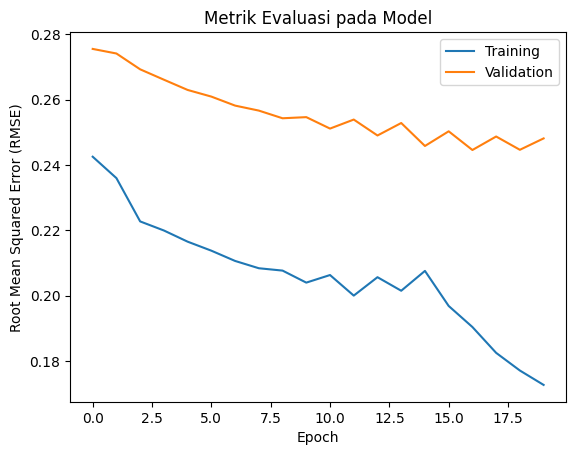

In [ ]:
# Membuat line plot untuk menunjukkan metrik evaluasi
plt.plot(history.history["root_mean_squared_error"])
plt.plot(history.history["val_root_mean_squared_error"])

# Menambahkan judul, label, dan legend pada plot
plt.title("Metrik Evaluasi pada Model")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.xlabel("Epoch")
plt.legend(["Training", "Validation"], loc = "upper right")

# Menampilkan plot
plt.show()

Pada hasil evaluasi dapat dilihat untuk akurasi training rmse terus menurun hingga epoch 20. Namun untuk validation rmse, penurunan terhenti pada epoch 10 dan terjadi naik turun untuk hasilnya.